I took some ideas from this awesome kaggle notebook: https://www.kaggle.com/code/tanmay111999/clustering-pca-k-means-dbscan-hierarchical/notebook, I highly recommend it to check it out.


In [1]:
import plotly.io as pio
pio.renderers.default = "jpg"

import os
os.environ['OMP_NUM_THREADS'] = "1"
# import libraries

# the basic ones
import numpy as np
import pandas as pd

# pipeline and column trasnformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Imputing numerical data
from sklearn.preprocessing import StandardScaler

# we will use this one (for categorical columns) to lower the amount of columns and work a little faster
from sklearn.preprocessing import TargetEncoder

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# for GMM
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score

# new library, we haven't used this one before in this repo
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Here I will be working with the same data as in the previous notebook, but we will try other clustering techniques.

In [2]:
np.random.seed(0)
X = pd.read_csv('data_customers.csv') # , index_col='fullVisitorId'
X['movilidad_dispositivo'] = X['device.deviceCategory']
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].apply(lambda x: -1 if str(x)=='desktop' else x)
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].apply(lambda x: 0 if str(x)=='tablet' else x)
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].apply(lambda x: 1 if str(x)=='mobile' else x)
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].astype('int64')
X_original = X.copy()
X.drop(['device.deviceCategory','device.isMobile'], axis=1, inplace=True)
X.drop(['sessionId'], axis=1, inplace=True)
X.set_index(['fullVisitorId'])

,channelGrouping,weekend_prop,hour,device.browser,device.operatingSystem,totals.hits,totals.pageviews,bounce_prop,trafficSource.medium,movilidad_dispositivo
fullVisitorId,,,,,,,,,,
213131142648941,Direct,0.000000,22.0,Chrome,Macintosh,14.0,13.0,0.0,(none),-1
435324061339869,Referral,0.666667,21.0,Chrome,Macintosh,14.0,11.0,0.0,referral,-1
562678147042735,Organic Search,0.000000,14.0,Chrome,Macintosh,12.5,10.5,0.0,organic,-1
585708896049892,Referral,0.000000,20.0,Chrome,Linux,22.0,20.0,0.0,referral,-1
670722016498267,Referral,0.000000,17.0,Chrome,Linux,9.5,9.5,0.0,referral,-1
...,...,...,...,...,...,...,...,...,...,...
9991633376050115277,Social,0.000000,0.0,Chrome,Linux,17.0,16.0,0.0,referral,-1
9994767073213036303,Organic Search,0.000000,20.0,Chrome,Windows,42.0,30.0,0.0,organic,-1
9997409246962677759,Referral,0.000000,2.0,Chrome,Macintosh,86.0,65.0,0.0,referral,-1


In [3]:
features = [ "totals.pageviews", "bounce_prop", "hour", "movilidad_dispositivo","weekend_prop"]
X = X[features]

In [4]:
neighbor = 2*len(features)
minPts = 2*len(features) + 1
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

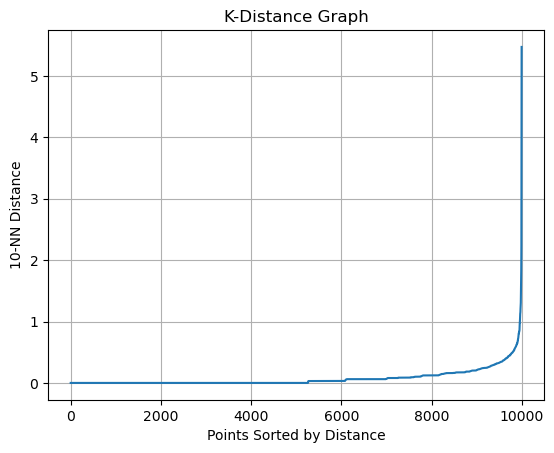

In [5]:
knn = NearestNeighbors(n_neighbors = neighbor)
model = knn.fit(X_transform)
distances, indices = knn.kneighbors(X_transform)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances);
plt.xlabel('Points Sorted by Distance')
plt.ylabel(f'{neighbor}-NN Distance')
plt.title('K-Distance Graph');

In [6]:
db = DBSCAN(eps = 0.4, min_samples = minPts).fit(X_transform)

In [7]:
X['clusters'] = db.labels_

Proporción de cada Cluster


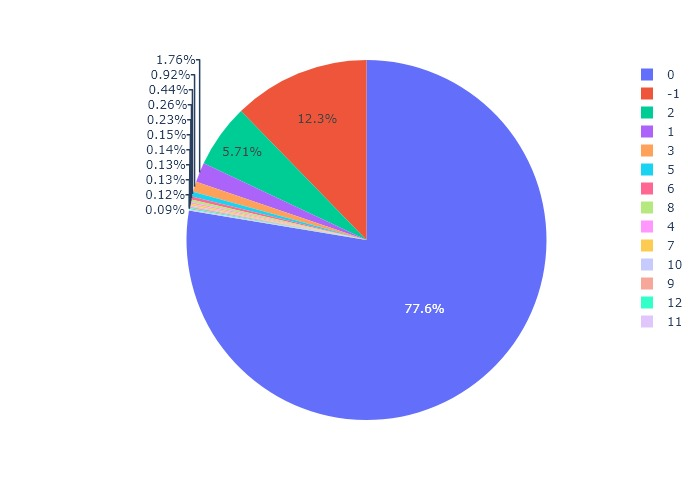

In [8]:
print("Proporción de cada Cluster")
X['numero_usuarios_1'] = 1
fig = px.pie(X, values='numero_usuarios_1', names='clusters')
fig.show()

The -1 cluster are the noise cluster, the outliers. So there are only two big groups cluster 0 and cluster 2.

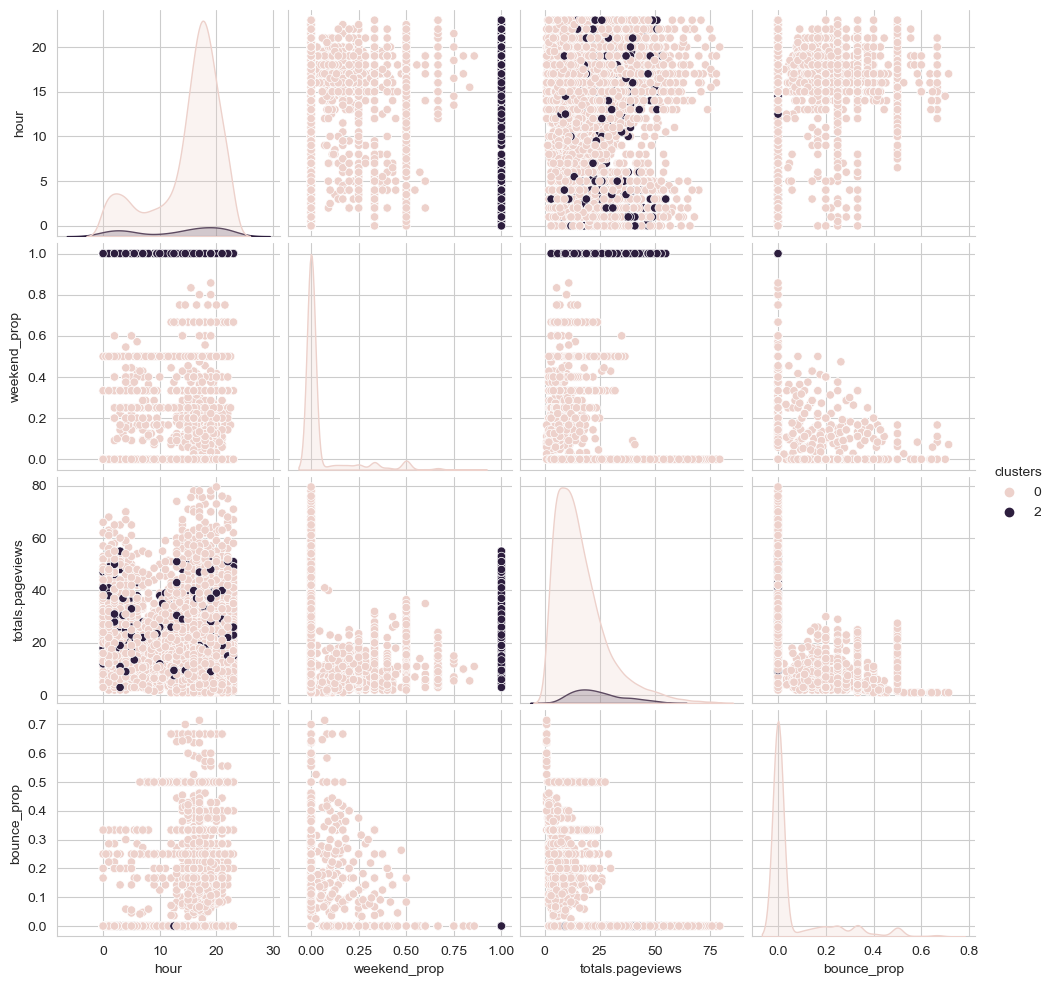

In [9]:
sns.set_style("whitegrid")
sns.color_palette("tab10")
g=sns.pairplot(X[(X['clusters']==2) | (X['clusters']==0)],vars=['hour', 'weekend_prop', 'totals.pageviews',
                            'bounce_prop'], hue='clusters')

In [10]:
big_clusters = X[(X['clusters']==2) | (X['clusters']==0)].copy()

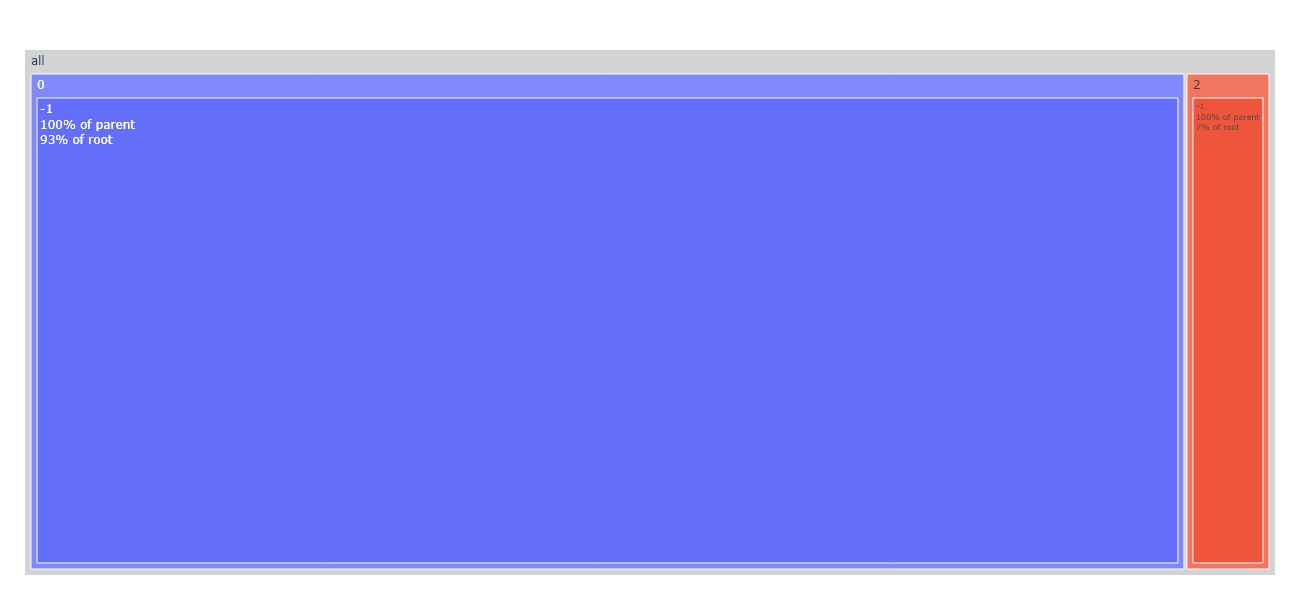

In [11]:
fig = px.treemap(big_clusters, path=[px.Constant("all"),'clusters','movilidad_dispositivo'], 
                 values='numero_usuarios_1', width=1300, height=600)
fig.update_traces(root_color="lightgrey" ,textinfo = "label+percent parent+percent root")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

Interesting enough, all customer in cluster 0 and 2 use computer, so what is the problem? Well we need to consider this is a categorical variable in essence , it was likely to be cluster together giving how this algorithm work. So, we could take out the variable movilidad_dispositivo to avoid this problem. 
But still we have some groups created with this algorithm, let us explore what it actually did.

totals.pageviews


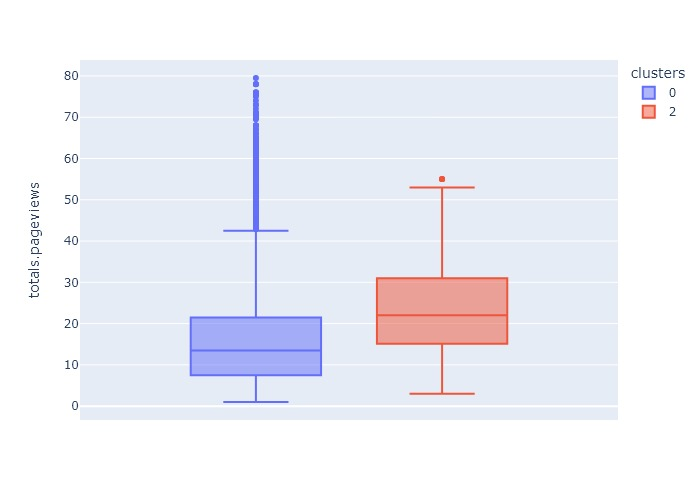

weekend_prop


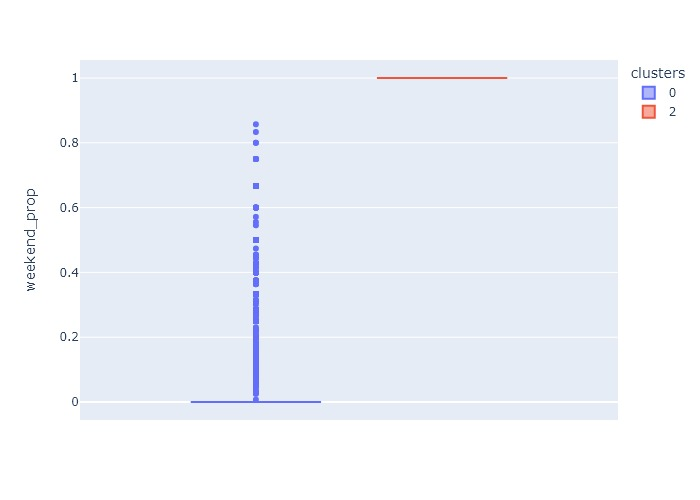

In [12]:
posibles_outliers = ["totals.pageviews","weekend_prop"]
for outlier in posibles_outliers:
    print(outlier)
    fig = px.box(big_clusters, y=outlier, color="clusters")
    fig.show()

So cluster 2 are just the clients that connects at weekend it was big enough neiborhood to be consider a cluster on its own (by the model), it was 5% of the customer. Group 1 are consumer that navigate less and have a wide range of behaviours. These are "normal" clients. Notice 12% has such an "weird" behaviour that they do not have "enough" neighbors (*minPts* variable) close by (eps variable) (label -1).

Notice the algorith took out all outliers, let us compare it with what we had at the beginning.

original data totals.pageviews


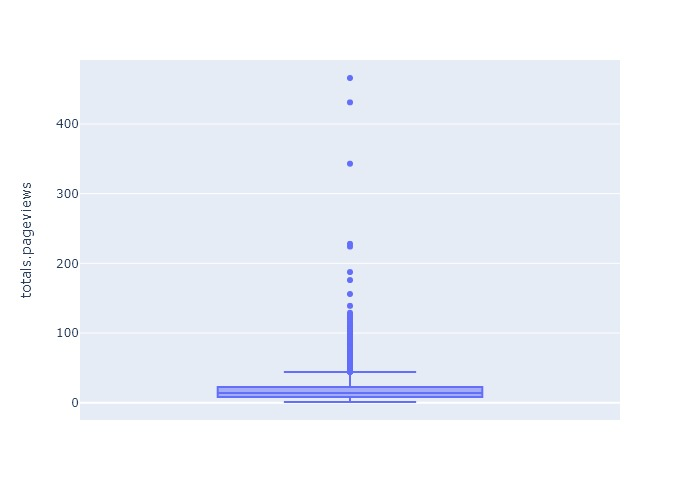

original data weekend_prop


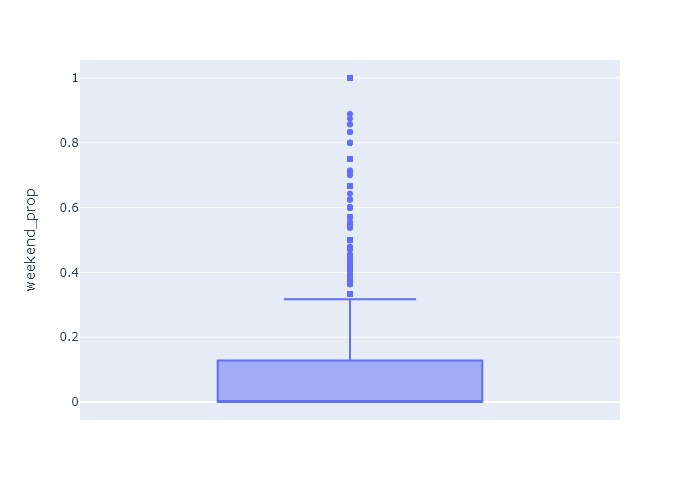

In [15]:
posibles_outliers = ["totals.pageviews","weekend_prop"]
for outlier in posibles_outliers:
    print(f"original data {outlier}")
    fig = px.box(X_original, y=outlier)
    fig.show()